# Moving averages


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint

from utils import get_data, get_return_simulation


In [2]:
PATH = "../data/movin_averages.csv"
stocks = ["MFED.PA", "PE500.PA", "EN.PA", "CNP.PA", "TTE.PA", "^GSPC"]


## Get stocks data


array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

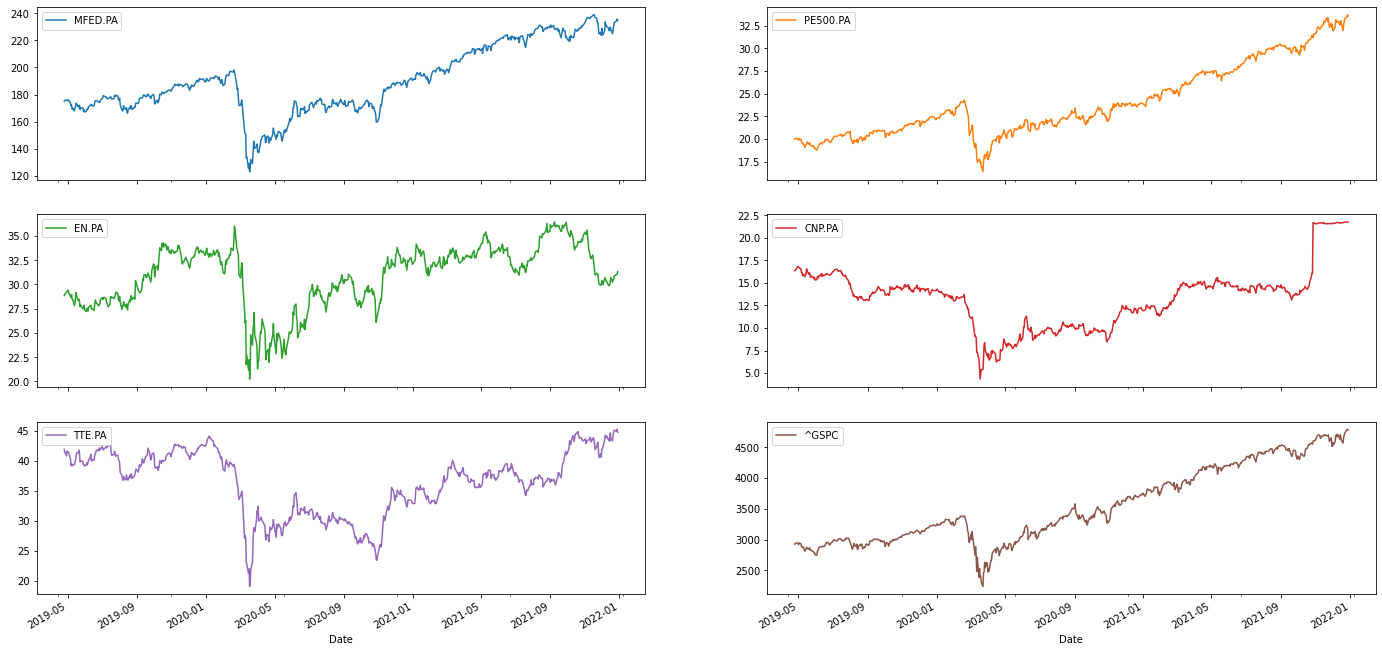

In [3]:
df = get_data(path=PATH, stocks=stocks)

df.plot(figsize=(24, 12), subplots=True, layout=(3, 2))


## Example of a strategy base on 2 simple moving averages


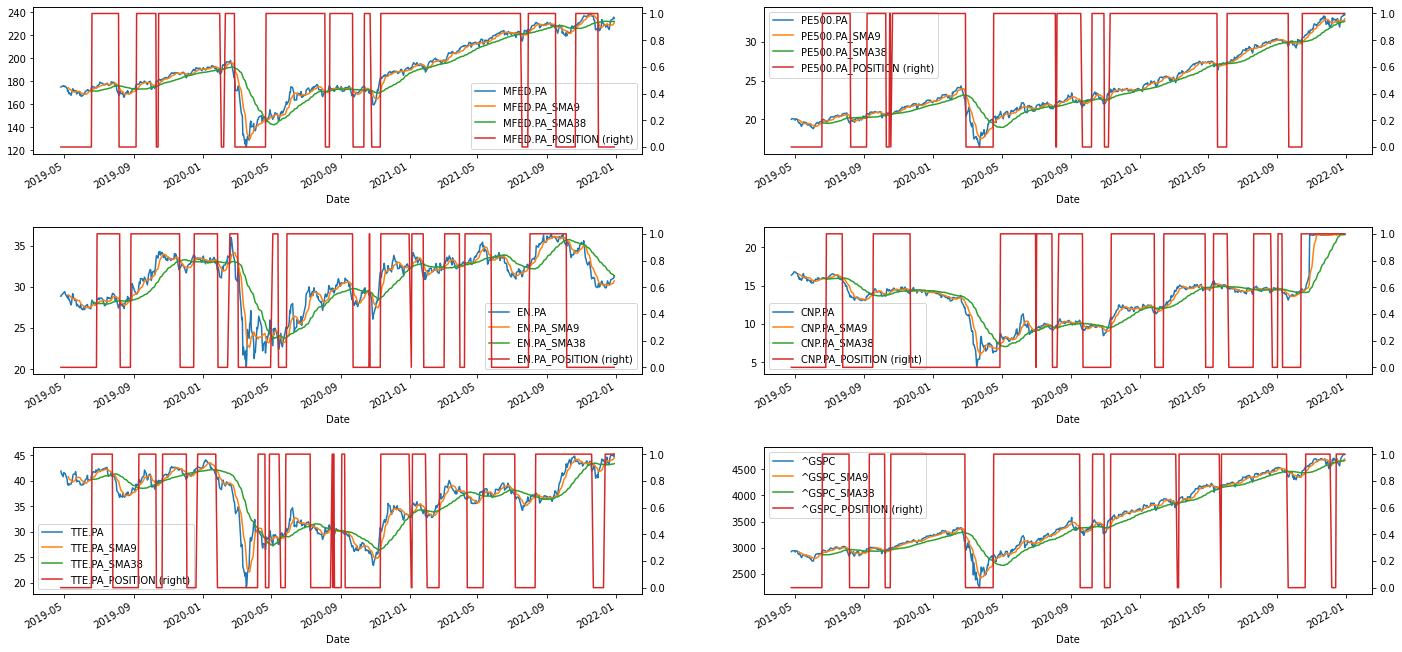

In [8]:
SMA1 = 9
SMA2 = 38

fig, axes = plt.subplots(nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    df[f"{s}_SMA{SMA1}"] = df[s].rolling(SMA1).mean()
    df[f"{s}_SMA{SMA2}"] = df[s].rolling(SMA2).mean()
    df[f"{s}_POSITION"] = np.where(df[f"{s}_SMA{SMA1}"] > df[f"{s}_SMA{SMA2}"], 1, 0)

    df[[s, f"{s}_SMA{SMA1}", f"{s}_SMA{SMA2}", f"{s}_POSITION"]].plot(
        figsize=(24, 12), ax=axes[i // 2, i % 2], secondary_y=f"{s}_POSITION"
    )


## Compute strategy returns and compare to stock returns


{'CNP.PA': {'amount invested': 156.73144721984863,
            'base returns': 1.3298480382757274,
            'strategy returns': 1.6660345283503097},
 'EN.PA': {'amount invested': 392.37864112854004,
           'base returns': 1.0857877957232231,
           'strategy returns': 1.0376711506560647},
 'MFED.PA': {'amount invested': 2036.6099700927734,
             'base returns': 1.3412752500825842,
             'strategy returns': 1.267915819877073},
 'PE500.PA': {'amount invested': 249.2770004272461,
              'base returns': 1.6770999908447266,
              'strategy returns': 1.4801285210968576},
 'TTE.PA': {'amount invested': 608.587324142456,
            'base returns': 1.0673712024741513,
            'strategy returns': 1.2501657329620386},
 '^GSPC': {'amount invested': 39026.789306640625,
           'base returns': 1.634310428721418,
           'strategy returns': 1.3479194970797335}}


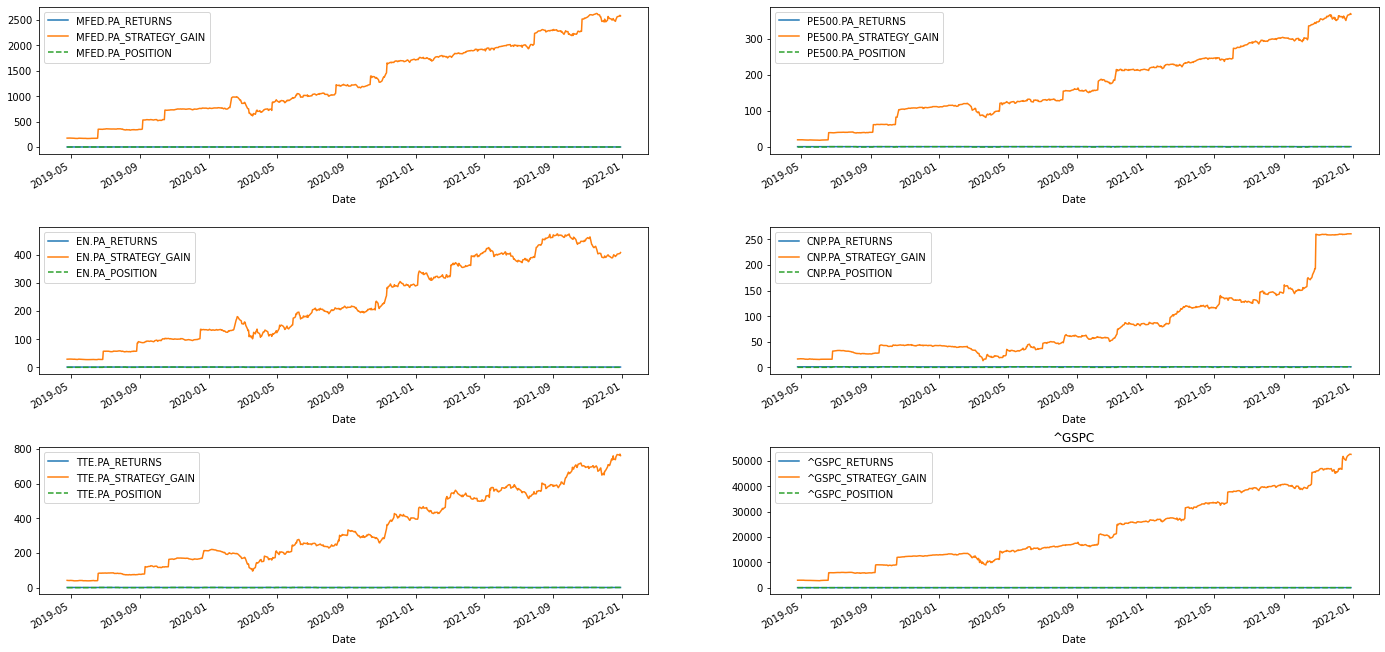

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for s in stocks:
    df[f"{s}_TRANSACTIONS"] = df[f"{s}_POSITION"].diff().clip(lower=0)
    df.loc[df.index[0], f"{s}_TRANSACTIONS"] = 1

pprint.pprint(get_return_simulation(df, stocks))

for i, s in enumerate(stocks):
    ax = df[[f"{s}_RETURNS", f"{s}_STRATEGY_GAIN"]].plot(
        figsize=(24, 12), ax=axes[i // 2, i % 2]
    )
    df[[f"{s}_POSITION"]].plot(
        figsize=(24, 12), ax=ax, secondary_y=f"position_{s}", style="--"
    )
    plt.title(s)


## Compute best simple moving average pair


In [6]:
symbols = stocks[:-1]
results = pd.DataFrame()

data = pd.DataFrame(df[symbols])
data.dropna(inplace=True)

for SMA1 in range(2, 51):
    for SMA2 in range(SMA1 + 1, 51):
        for s in symbols:
            data[f"{s}_SMA1"] = data[s].rolling(SMA1).mean()
            data[f"{s}_SMA2"] = data[s].rolling(SMA2).mean()

            data[f"{s}_POSITION"] = np.where(
                data[f"{s}_SMA1"] > data[f"{s}_SMA2"], 1, 0
            )
            data[f"{s}_TRANSACTIONS"] = data[f"{s}_POSITION"].diff().clip(lower=0)
            data.loc[data.index[0], f"{s}_TRANSACTIONS"] = 1

        return_simulation = get_return_simulation(data, symbols)
        market = sum([return_simulation[s]["base returns"] for s in symbols])
        strategy = sum([return_simulation[s]["strategy returns"] for s in symbols])

        results = results.append(
            pd.DataFrame(
                {
                    "SMA1": SMA1,
                    "SMA2": SMA2,
                    "market": market,
                    "strategy": strategy,
                    "out": strategy - market,
                },
                index=[0],
            ),
            ignore_index=True,
        )

results.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      1176 non-null   int64  
 1   SMA2      1176 non-null   int64  
 2   market    1176 non-null   float64
 3   strategy  1176 non-null   float64
 4   out       1176 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 46.1 KB


In [7]:
results.sort_values("out", ascending=False).head(7)


,SMA1,SMA2,market,strategy,out
343,9,38,6.501382,6.701916,0.200533
342,9,37,6.501382,6.701071,0.199689
382,10,37,6.501382,6.688816,0.187434
171,5,36,6.501382,6.679871,0.178488
344,9,39,6.501382,6.674829,0.173447
376,10,31,6.501382,6.669240,0.167858
803,23,29,6.501382,6.668111,0.166729


## Conclusion

- We did not find a SMA pair that consistently have higher returns than staying in the market
- In the method to find the best pair, all stocks were equally weighted
- SMA cannot be used for buy/sell signals by itself

- Try with 3 SMA to generate signal
- Try to optimize with weights
